In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-03 16:22:50,399 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        if isinstance(specifics, list):
            assert np.allclose([s['avg_img'] for s in specifics], True)
            specifics = specifics[0]
        else:
            assert specifics['avg_img']
        if isinstance(y, list):
            y = pd.concat(y)
        if isinstance(y_pred, list):
            y_pred = pd.concat(y_pred)
            
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
            'best_train_cost': specifics['best_train_score'][0],
            'idx_fold': specifics['idx_fold'],
            'y_test': y,
            'y_pred': y_pred,
            'n_samples': len(y),
            'n_folds': specifics['n_folds'],
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        data.append(row)
    return pd.DataFrame(data)

In [3]:
def calc_test_cost(grouped_data, verbose=True):
    compact_data = []
    for (subject, model, adjust_bias), data in grouped_data:
        if verbose:
            print('- Processing %s, %s %s' % (subject, model, adjust_bias))
        # Aggregate test data from all folds:
        y_test = pd.DataFrame([{'area': float(row['area']),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_test']], index=data.index)
        y_pred = pd.DataFrame([{'area': float(row['area']),
                                'orientation': float(row['orientation']),
                                'eccentricity': float(row['eccentricity']),
                                'compactness': float(row['compactness'])}
                               for row in data['y_pred']], index=data.index)
        y_test['orientation'] = np.rad2deg(y_test['orientation'])
        y_pred['orientation'] = np.rad2deg(y_pred['orientation'])

#         y_test['compactness'] = np.minimum(1, np.maximum(0, 1.0 / (y_test['compactness'] / (4 * np.pi))))
#         y_pred['compactness'] = np.minimum(1, np.maximum(0, 1.0 / (y_pred['compactness'] / (4 * np.pi))))
        
#         idx = np.isclose(y_pred['compactness'], 1)
#         y_pred['orientation'][idx] = 0
#         y_pred['eccentricity'][idx] = 0
#         idx = np.isclose(y_test['compactness'], 1)
#         y_test['orientation'][idx] = 0
#         y_test['eccentricity'][idx] = 0
            
        # Calculate r2:
        best_cost = 0
        r2_scores = {}
        for col in y_test.columns:
            yt = y_test.loc[:, col]
            yp = y_pred.loc[:, col]

            if col == 'orientation':
                # Use circular error:
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                # Use circular variance in `ss_tot`, which divides by len(yt).
                # Therefore, we also need to divide `ss_res` by len(yt), which
                # is the same as taking the mean instead of the sum.
                ss_res = np.mean(err ** 2)
                ss_tot = spst.circvar(yt, low=-90, high=90)
                r2_scores['r2_orientation'] = 1 - ss_res / (ss_tot + 1e-12)
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            if verbose:
                print('  - Processing %s: r2=%f' % (col, r2_scores['r2_' + col]))
            
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        compact_row = {
            'subject': subject,
            'model': model,
            'adjust_bias': adjust_bias,
            'best_test_cost': best_cost,
            'y_test': y_test,
            'y_pred': y_pred,
        }
        compact_row.update(r2_scores)
        compact_data.append(compact_row)
    return pd.DataFrame(compact_data)

In [4]:
results_dir = '../../results/shape8cv/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 7 files


In [5]:
subjects = ['TB', '12-005', '51-009', '52-001']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [6]:
data = load_data(pickle_files, verbose=False)

In [7]:
data.columns

Index(['adjust_bias', 'best_train_cost', 'exetime', 'filename', 'filepath',
       'idx_fold', 'model', 'n_folds', 'n_samples', 'subject', 'y_pred',
       'y_test'],
      dtype='object')

# All runs

In [8]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
predcols = ['area', 'orientation', 'eccentricity', 'compactness']
r2cols = ['r2_%s' % name for name in predcols]

In [9]:
data.groupby(groupcols + ['idx_fold'], sort=False)['exetime', 'best_train_cost'].agg(['mean', 'std', 'count'])

exetime           best_train_cost      \
                                           mean std count            mean std   
subject model adjust_bias idx_fold                                              
TB      C     False       0          719.184646 NaN     1        7.632619 NaN   
                          1         2018.496984 NaN     1        4.300310 NaN   
                          2          804.565960 NaN     1        5.948967 NaN   
                          3         1445.649070 NaN     1        5.077961 NaN   
                          4         2005.187232 NaN     1        5.059254 NaN   
                          5         2273.688582 NaN     1        5.559382 NaN   
                          6         3277.801027 NaN     1        5.455404 NaN   

                                          
                                   count  
subject model adjust_bias idx_fold        
TB      C     False       0            1  
                          1            1  
                          2            1  
                          3            1  
                          4            1  
                          5            1  
                          6            1

# The best runs in their respective category

In [10]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols + ['idx_fold'])['best_train_cost'].idxmin()
data.loc[best_idx, :].drop(columns=extracols).groupby(groupcols + ['idx_fold'])['best_train_cost'].agg(['count',
                                                                                                        'min'])

Best scores:


count       min
subject model adjust_bias idx_fold                 
TB      C     False       0             1  7.632619
                          1             1  4.300310
                          2             1  5.948967
                          3             1  5.077961
                          4             1  5.059254
                          5             1  5.559382
                          6             1  5.455404

In [11]:
best = calc_test_cost(data.loc[best_idx, :].groupby(groupcols, sort=False), verbose=False)
best

,adjust_bias,best_test_cost,model,r2_area,r2_compactness,r2_eccentricity,r2_orientation,subject,y_pred,y_test
0,False,11.350397,C,-1.901666,-1.996269,-4.134773,0.682311,TB,area compactness eccentricity orientati...,area compactness eccentricity orientat...


# Plot predictions

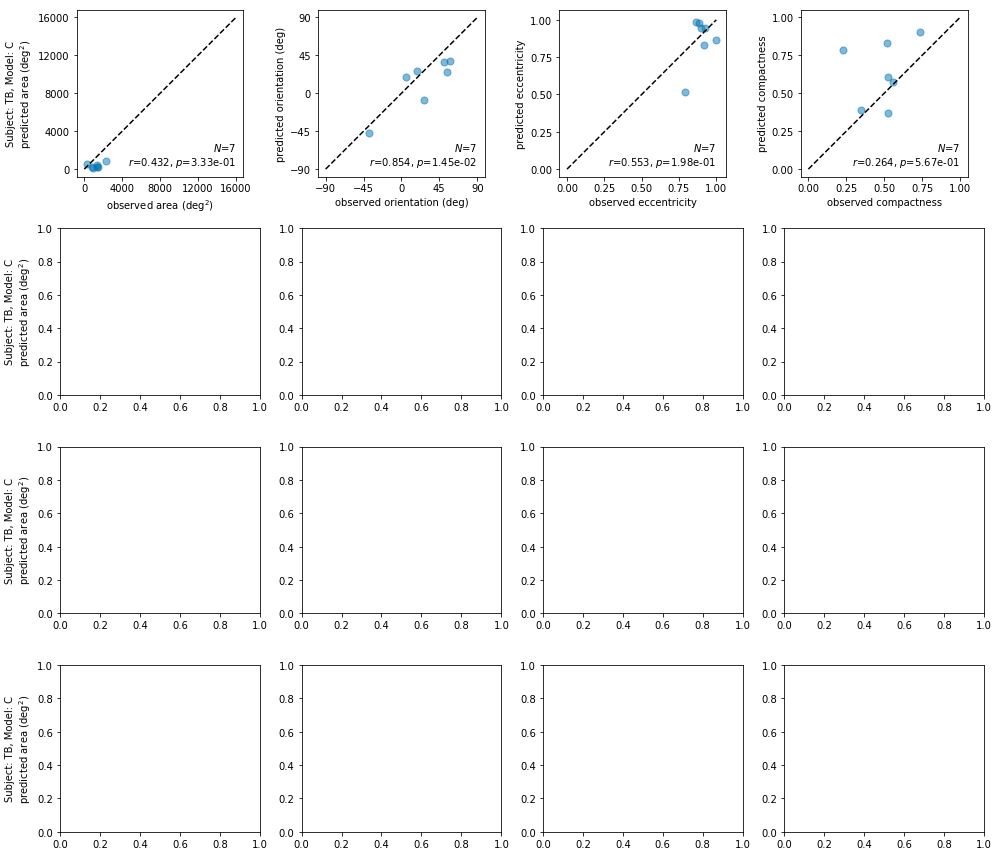

In [12]:
plotmodel = 'C'
fig, axes = plt.subplots(ncols=len(predcols), nrows=len(subjects), 
                         figsize=(14, 3 * len(subjects)))
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
ticks = [[0, 16000], [-90, 90], [0, 1], [0, 1]]
limits = [[-1600, 16600], [-108, 108], [-0.1, 1.1], [-0.1, 1.1]]
labels = ['area (deg$^2$)', 'orientation (deg)', 'eccentricity', 'compactness']
for subject, marker, color, axrow in zip(subjects, markers, colors, axes):
    for _, row in best[np.logical_and(best['subject'] == subject, best['model'] == plotmodel)].iterrows():
        for col, ax, tick, lim, label in zip(predcols, axrow, ticks, limits, labels):
            y = row['y_test']
            y_pred = row['y_pred']
            ax.scatter(y[col], y_pred[col], marker=marker, s=50, c=color, alpha=0.5)
            ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
            ax.set_xticks(np.linspace(*tick, num=5))
            ax.set_yticks(np.linspace(*tick, num=5))
            ax.set_xlim(*lim)
            ax.set_ylim(*lim)
            ax.set_xlabel('observed %s' % label)
            ax.set_ylabel('predicted %s' % label)
            ax.axis('square')
            slope, intercept, rval, pval, _ = spst.linregress(y[col], y_pred[col])
            ax.text(tick[1], tick[0], "$N$=%d\n$r$=%.3f, $p$=%.2e" % (len(y), rval, pval), va='bottom', ha='right')
        break
    axrow[0].set_ylabel('Subject: %s, Model: %s\npredicted %s' % (row['subject'], row['model'], labels[0]))
fig.tight_layout()
fig.savefig('predict-cv-%s.png' % plotmodel)